## Energy Flow Tutorial

[EnergyFlow website](https://pkomiske.github.io/EnergyFlow/)

### Energy Flow Polynomials

In this tutorial, we introduce the EnergyFlow package for computing arbitrary Energy Flow Polynomials (EFPs) and collections of EFPs. The package is built with both usability, flexibility, and computational efficiency in mind.

For a collection of $M$ particles with energy measure $z_i$ and pairwise angular distance measures $\theta_{ij}$, the EFPs are multiparticle energy correlator observables, indexed by multigraphs $G$, and defined as:
$$ \mathrm{EFP}_G = \sum_{i_1=1}^M \sum_{i_2=1}^M\cdots \sum_{i_N=1}^M z_{i_1}z_{i_2}\cdots z_{i_N} \prod_{(k,\ell)\in G} \theta_{i_ki_\ell},$$
where $(k,\ell)\in G$ iterates over the edges in the multigraph.

### Choices of Measure

The specific choice of energy and angular measures depends on the collider context. We provide the following `measure` options (default is `hadrdot`):

`hadr`: $$ z_i = p_{T,i}^\kappa,\,\,\,\,\,\, \theta_{ij} = ((y_i - y_j)^2 + (\phi_i - \phi_j)^2)^{\beta/2} $$
`hadrdot`: $$ z_i = p_{T,i}^\kappa,\,\,\,\,\,\, \theta_{ij} = (2\, \hat p_i^\mu \hat p_{i\,\mu})^{\beta/2},\,\,\,\,\,\, \mathrm{where }\,\,\,\,\,\,\hat p_i^\mu \equiv p_i^\mu/p_{T,i}  $$
`ee`: $$ z_i = E_i^\kappa,\,\,\,\,\,\, \theta_{ij} = (2\, \hat p_i^\mu \hat p_{i\,\mu})^{\beta/2},\,\,\,\,\,\, \mathrm{where }\,\,\,\,\,\,\hat p_i^\mu \equiv p_i^\mu/E_i $$

The energy and angular weighting parameters `kappa` and `beta` default to $\kappa=1$ and $\beta = 2$. The choice of $\kappa = 1$ is required for infrared and collinear (IRC) safety of the observables. Any choice of $\beta > 0$ guarantees IRC safety. We also provide the `normed` option (default is `True`) to use a normalized and dimensionless energy measure $z_i/\sum_{j=1}^M z_j$ rather than $z_i$.

With this refresher, we have enough to begin using EnergyFlow to compute arbitrary EFPs! Ensure you have EnergyFlow installed. It is easily `pip` installable by executing:
` pip install energyflow `

We start by importing the EnergyFlow package as well as some other helpful Python libraries.

In [1]:
import energyflow as ef
import numpy as np

### Obtaining Events
Let's get some events. Typically these would be read in from your favorite event generator for your physics case of interest.

For the purposes of this tutorial, we will uniformly sample massless $M$-body phase space with the use of our implementation of the [RAMBO](https://www.sciencedirect.com/science/article/pii/0010465586901190?via%3Dihub) algorithm via the function `ef.gen_massless_phase_space`. It returns `nevents` events consisting of `nparticles` massless four-momenta with center of mass energy of `energy` in the center of momentum frame. In general, EnergyFlow supports events as arrays of four-momenta `[E,px,py,pz]` or arrays of hadronic coordinates `[pT,y,phi]` for hadronic measures.

Let's generate 50 events with 20 particles each at center of mass energy 100 GeV.

In [4]:
events = ef.gen_massless_phase_space(nevents=50, nparticles=20, energy=100)

### Defining Graphs

To specify a particular EFP to be computed for our events, we must simply specify the corresponding multigraph.


In EnergyFlow, multigraphs are specified as lists of edges, where edges are pairs of vertices. Here are several examples of graphs given as edge lists, where we label the vertices with integers from $0$ to $N-1$.

In [5]:
line     = [(0,1)]
wedge    = [(0,1), (0,2)]
triangle = [(0,1), (0,2), (1,2)]
square   = [(0,1), (1,2), (2,3), (3,1)]

Multigraphs can have multiple edges per pair of vertices. Here are several examples of multigraphs as edgelists, with one or more doubled edges.

In [6]:
multiline      = [(0,1), (0,1)]
multiwedge1    = [(0,1), (0,1), (0,2)]
multiwedge2    = [(0,1), (0,1), (0,2), (0,2)]
multitriangle1 = [(0,1), (0,2), (0,2), (1,2)]

In fact, arbitrary objects can be used to label the vertices. We typically use integer-labeling for simplicity and readibility, though this is not required. The following two edge lists both define the _same_ graph from the perspective of EnergyFlow.

In [7]:
graph_LHC  = [('atlas','cms'),('atlas','cms'),('atlas','lhcb'),('cms','lhcb'),('lhcb','alice')]
graph_ints = [(0,1),(0,1),(0,2),(1,2),(2,3)]

### Computing an Energy Flow Polynomial

EFPs are defined by passing a graph and measure choies to `ef.EFP`. The `compute` method of `ef.EFP` can then be called on an event in order to compute the EFP on that event.

For concreteness, let's begin by defining the EFP corresponding to the line graph `[(0,1)]` (one edge connecting two vertices) which should be equal to twice the squared center of mass energy of the event with a suitable choice of measure parameters.

In [8]:
# Computing a single EFP on a single event

# specify a graph and event
graph = [(0,1)]
event = events[0]

# define the EFP corresponding to the specified graph
EFP_graph = ef.EFP(graph, measure='hadr', beta=1, normed=False)

# compute the EFP on the specified event
result = EFP_graph.compute(event)

print("EFP Value:", result)

EFP Value: 7919.65604201059


We can see that the value of this EFP is indeed $\mathrm{EFP}_{[(0,1)]} = 2\times E_\mathrm{CM}^2 = 2\times (100\,\mathrm{GeV})^2 = 20\,000\, \mathrm{GeV}^2$, as expected for our events.

The framework above can be immediately extended to computing the value of an EFP on a collection of many events. This can either be done with list comprehension or even more simply using the `batch_compute` method, which tries to use as many processes as there are CPUs in the machine. The number of worker processes can be controlled by passing in `n_jobs`.

In [9]:
# Computing a single EFP on many events

# specify a graph
graph = [(0,1), (0,2), (0,2), (1,2)]

# define the EFP corresponding to the specified graph
efp_graph = ef.EFP(graph, measure='hadr', beta=1, normed=True)

# compute the EFP on the collection of events with list comprehension
results = np.asarray([efp_graph.compute(event) for event in events])
print("EFP w. list comprehension:", results)

EFP w. list comprehension: [22.66604653 13.43431317 19.65956076  8.45945123 12.12876269 12.88074759
 11.37389838 11.50562533 12.00564187 11.41550327 12.89255349 16.94599659
 10.70664699 12.37644928 13.98030762 12.32225291 11.16754783 13.20900011
 15.75739743 24.4226896  12.15335956 10.85358241 14.30542211 11.3656036
 11.12196912 12.73791728 10.25291886 16.1133345  14.1399483  15.21551224
 19.8257645  10.9879271  12.41152087 10.99418405 11.21102208 10.04907927
 10.40675078 11.6023411  16.31701915 20.25400689 17.81417842 11.62225968
 16.1045497  12.7442648  12.64738592 13.8396214  12.57896258 14.02510864
 11.38155385 17.93099545]
EFP w. batch_compute:      [22.66604653 13.43431317 19.65956076  8.45945123 12.12876269 12.88074759
 11.37389838 11.50562533 12.00564187 11.41550327 12.89255349 16.94599659
 10.70664699 12.37644928 13.98030762 12.32225291 11.16754783 13.20900011
 15.75739743 24.4226896  12.15335956 10.85358241 14.30542211 11.3656036
 11.12196912 12.73791728 10.25291886 16.113334

### Computing a set of Energy Flow Polynomials

If we are interested in using the spanning properties of EFPs, we typically want to compute large numbers of EFPs. The EnergyFlow package does the heavy lifting for you! It contains information about all multigraphs with up to 10 edges, which can be easily and intuitively accessed using `EFPSet`.

Relevant graph quantities which can easily be used to select a set of multigraphs are summarized below. More options are available: for a full list see the [documentation](https://pkomiske.github.io/EnergyFlow/).

`n` : Number of vertices in the multigraph.

`d` : Degree, or number of edges in the multigraph.

`v` : Maximum valency (number of edges touching a vertex).

`c` : Variable Elimination computational complexity $\mathcal O(M^c)$

`p` : Number of prime factors (or connected components of the multigraph).

As a basis, EFPs are typically organized by the number of edges `d`. Not only does this correspond to the degree of the polynomial, but there are also a _finite_ number of multigraphs up to a specified degree `d`. Lets get  all EFPs with up to five edges by passing `d<=5` to `EFPSet` and compute them on our events!

In [10]:
# get all EFPs with d<=5 (up to d<=10 available by default)
efpset = ef.EFPSet('d<=5', measure='hadr', beta=1, normed=True, verbose=True)

# compute their values on our events
results = np.asarray([efpset.compute(event) for event in events])

print("Results:", results)

Originally Available EFPs:
  Prime: 23690
  Composite: 21540
  Total:  45230
Current Stored EFPs:
  Prime: 53
  Composite: 48
  Total:  101
Results: [[ 2.07534051  5.31944855 15.06478242 ... 47.54826816 39.10186566
  38.49876673]
 [ 1.85169119  4.3252484  10.98254093 ... 27.46102424 21.93830013
  21.76921637]
 [ 2.01211404  5.01906771 13.77000864 ... 40.88658398 33.43755276
  32.98093432]
 ...
 [ 1.87913474  4.43340555 11.43188887 ... 29.41787    23.55149797
  23.43093429]
 [ 1.77350654  4.07514151 10.23922572 ... 22.73217942 17.72080204
  17.54542805]
 [ 1.96806544  4.723103   12.39396925 ... 36.00360791 29.8939128
  29.52552835]]


We can very easily do much more sophisticated EFP selections using any of the graph quantities. For example to select all prime EFPs with at most 4 vertices and at most 5 edges, we simply use `EFPSet` with the following intuitive syntax:

In [11]:
# get all EFPs with n<=4, d<=5, that are prime (i.e. p==1)
efpset = ef.EFPSet(('n<=',6), ('d<=',5), ('p==',1), measure='hadr', beta=1, normed=True, verbose=True)

# compute their values on our events
results = np.asarray([efpset.compute(event) for event in events])

Originally Available EFPs:
  Prime: 23690
  Composite: 21540
  Total:  45230
Current Stored EFPs:
  Prime: 53
  Composite: 0
  Total:  53


To study the properties of an individual EFP within `EFPSet` we can easily do this using `specs` and `graphs`. Suppose we are interested in the 95th EFP. We can find out its graph and all of its relevant information simply with the following syntax. Here we show only a subset of all the information that specs provides about an EFP: for a full list see the [documentation](https://pkomiske.github.io/EnergyFlow/).

In [12]:
efpset = ef.EFPSet('d<=5', measure='hadr', beta=1, normed=True, verbose=True)

ind = 95
graph = efpset.graphs(ind)
n, _, d, v, _, c, p, _ = efpset.specs[ind]

print("Graph:", graph)
print("Number of vertices, n:", n)
print("Number of edges,    d:", d)
print("Maximum valency,    v:", v)
print("VE complexity,      c:", c)
print("Number of primes,   p:", p)

Originally Available EFPs:
  Prime: 23690
  Composite: 21540
  Total:  45230
Current Stored EFPs:
  Prime: 53
  Composite: 48
  Total:  101
Graph: [(0, 1), (2, 3), (4, 5), (4, 6), (4, 7)]
Number of vertices, n: 8
Number of edges,    d: 5
Maximum valency,    v: 3
VE complexity,      c: 2
Number of primes,   p: 3


### Working with actual jets

In [19]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_curve, roc_auc_score
import os
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
# load in events

# may need to change path depending on where the file is
path = 'Networks/events/'
filename = 'QCD-Top_10k.pickle'

events = np.load(os.path.join(path, filename))
labels = np.concatenate((np.zeros(5000), np.ones(5000)))

In [32]:
# specify a "small" EFPSet
dmax = 5
cmax = 2
efpset = ef.EFPSet(('d<=', dmax), ('c<=', cmax), measure='hadr', beta=1, verbose=True)

Originally Available EFPs:
  Prime: 23690
  Composite: 21540
  Total:  45230
Current Stored EFPs:
  Prime: 37
  Composite: 41
  Total:  78


In [33]:
# compute EFPs
%time efps = np.asarray([efpset.compute(event) for event in events])

CPU times: user 1min 20s, sys: 271 ms, total: 1min 21s
Wall time: 1min 21s


In [34]:
# see that you can train a single model
model = LinearDiscriminantAnalysis(tol=10**-10)
model.fit(efps, labels)
preds = model.predict_proba(efps)[:,1]

# find the AUC of the ROC curve
roc_auc_score(labels, preds)

0.97590316

In [35]:
# dictionaries to store ROCs
roc_curves = {}
aucs = {}

# iterate over the dmax 
for d in range(1, dmax+1):
    
    # get a fresh LDA model
    model = LinearDiscriminantAnalysis(tol=10**-10)
    
    # select only those EFPs with d <= dmax
    dmax_mask = efpset.sel(('d<=', d))
    efps_dmax = efps[:,dmax_mask]
    
    # fit model
    model.fit(efps_dmax, labels)
    
    # get predictions
    preds = model.predict_proba(efps_dmax)[:,1]
    
    # store ROCs
    roc_curves[d] = roc_curve(labels, preds)
    aucs[d] = roc_auc_score(labels, preds)

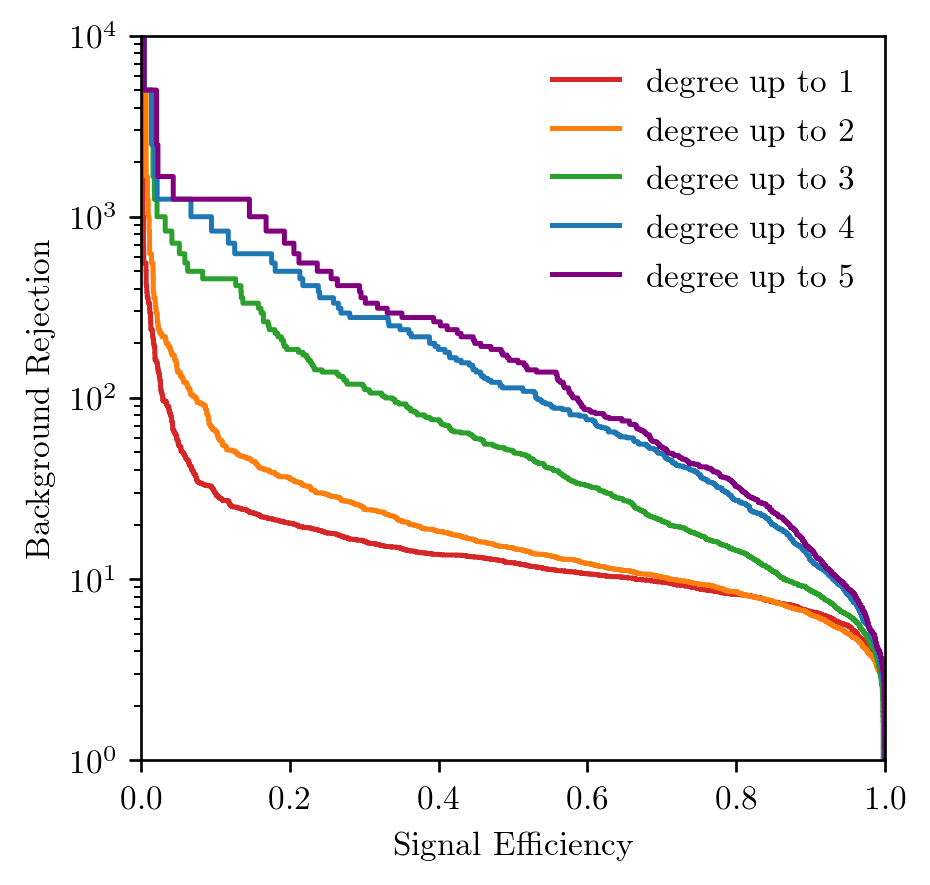

In [36]:
colors = ['tab:red', 'tab:orange', 'tab:green', 'tab:blue', 'purple']
for i,(d,roc) in enumerate(roc_curves.items()):
    plt.plot(roc[1], 1/(roc[0]+10**-8), '-', color=colors[i], label=r'degree up to '+str(d))

plt.yscale('log')
plt.xlim(0, 1)
plt.ylim(1, 10**4)

plt.xlabel('Signal Efficiency')
plt.ylabel('Background Rejection')

plt.legend(loc='upper right', frameon=False)
plt.show()

### Custom measures

If you want to specify your own custom measure for $z_i$ and $\theta_{ij}$ to be used in the EFP formula, that's also possible within the EnergyFlow package. You simply compute your own custom-defined `zs` and `thetas` on the events and pass them to the `compute` methods.

We demonstrate this below by using random numbers for `zs` and `thetas`, which can be replaced with any custom values.

In [11]:
# zs and thetas can be passed in explicitly if you want to use a custom measure
(zs, thetas) = (np.random.rand(100,25), np.random.rand(100,25,25))

results = np.asarray([efpset.compute(zs=z, thetas=theta) for (z,theta) in zip(zs,thetas)])
print(results)

[[1.15186438e+02 7.69068035e+01 5.78015000e+01 ... 1.17535431e+08
  1.36898595e+09 2.02771417e+10]
 [9.64046894e+01 6.37018005e+01 4.73836346e+01 ... 5.70750350e+07
  6.08828884e+08 8.32704283e+09]
 [7.19416458e+01 4.84149099e+01 3.68815022e+01 ... 1.80268662e+07
  1.60204481e+08 1.92708932e+09]
 ...
 [6.59271470e+01 4.36015963e+01 3.23252405e+01 ... 1.24938198e+07
  1.09820619e+08 1.24543599e+09]
 [7.77016944e+01 5.08128653e+01 3.73904956e+01 ... 2.38377441e+07
  2.31418239e+08 2.83238605e+09]
 [5.76998276e+01 3.85124726e+01 2.91119256e+01 ... 7.39818094e+06
  6.08408480e+07 6.39547164e+08]]


And that's it! Now you should be able to specify any EFP (i.e. multigraph) or set of EFPs that you want to comput with `EFP` or `EFPSet`, compute them on a set of events with `compute` or `batch_compute`, and study the results with `specs` and `graphs`! As always, see the [documentation](https://pkomiske.github.io/EnergyFlow/) for a full description of the EnergyFlow package.